# Import

In [1]:
import pandas as pd
import json
import numpy as np
import glob
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook


NAME_STR = "Name"
CLASS_STR = "Class"

# Form dataset

In [ ]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

In [ ]:
pathern = "data/names/*.txt"
temp_list = []
for file_name in glob.glob(pathern):
    base=os.path.basename(file_name)
    language = os.path.splitext(base)[0]

    df = pd.read_csv(file_name, header=None, names=[NAME_STR])
    df[NAME_STR] = df[NAME_STR].str.lower()
    df[NAME_STR] = df[NAME_STR].apply(lambda x: unicodeToAscii(x))
    df[CLASS_STR] = [language] * df.shape[0]
    temp_list.append(df)
    
names_df = pd.concat(temp_list)
names_df.to_csv("data/full_name_list.csv", index=False)

# Load dataset

In [2]:
names_df = pd.read_csv("data/full_name_list.csv")
names_df.sample(5)

,Name,Class
14401,galvin,English
19752,wilchek,Czech
3869,ebsvort,Russian
7671,pentin,Russian
16750,whyte,English


# Data analysis

In [3]:
import matplotlib.pyplot as plt

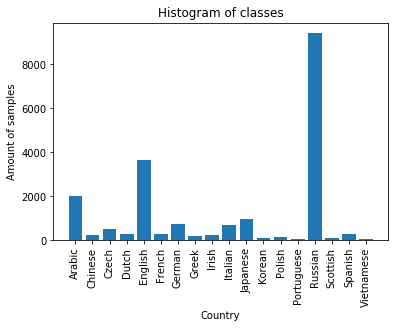

In [4]:
plot_data = np.unique(names_df[CLASS_STR], return_counts=True)
x_tick = range(len(plot_data[0]))
plt.bar(x_tick, plot_data[1], tick_label=plot_data[0])
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Amount of samples")
plt.title("Histogram of classes")
plt.show()

# Generation of vectors

In [5]:
class Convertor:
    
    def __init__(self, vocabular):
        letter_dict = {}
        for ind, letter in enumerate(vocabular):
            letter_dict[letter] = ind
            
        self.letter_dict = letter_dict
    
    def __call__(self, word_str):
        """
        Output: vector with shape (n_letter x 1 x vocabular_size)
        """
        vector = np.zeros((len(word_str), 1, len(self.letter_dict)))
        
        for let_pos, letter in enumerate(word_str):
            index = self.letter_dict[letter]
            vector[let_pos][0][index] = 1
        return vector

Encoding county name

In [6]:
country_dict = {}
index_country_dict = {}
for ind, country_name in enumerate(np.unique(names_df[CLASS_STR])):
    country_dict[country_name] = ind
    index_country_dict[ind] = country_name

Preparing letter vocabular

In [7]:
letters_set = set()
for ind, ser in names_df.iterrows():
    name_str = ser.get(NAME_STR)
    name_letter_set = set(name_str)
    letters_set = letters_set.union(name_letter_set)

letters_list = list(letters_set)
letters_list.sort()

Encoding each name

In [8]:
convertor = Convertor(letters_list)

vector_list = []
for ind, ser in names_df.iterrows():
    name_str = ser.get(NAME_STR)
    vector = convertor(name_str)
    vector_list.append(vector)

vector_np = np.array(vector_list)

# Wrap into torch dataset

In [9]:
class NameDataset(Dataset):
    
    def __init__(self, vector_np, name_np, country_np, country_dict):
        
        if vector_np.shape[0] != name_np.shape[0] and vector_np.shape[0] != country_np.shape[0]:
            raise Exception("Wrong dimentionality")
        
        self.vector_np = vector_np
        self.name_np = name_np
        self.country_np = country_np
        self.country_dict = country_dict
        
    def __len__(self):
        return self.vector_np.shape[0]
    
    def __getitem__(self, index):
        country_name = self.country_np[index]
        country_id = country_dict[country_name]
        return self.vector_np[index], country_id

In [10]:
def get_data_set(index, df, vector_np, country_map):
    vector_np = vector_np[index]
    names = df[NAME_STR].values[index]
    class_np = names_df[CLASS_STR].values[index]
    data_set = NameDataset(vector_np, names, class_np, country_map)
    return DataLoader(data_set, batch_size=1, shuffle=True)

In [11]:
X_train, X_test, _, _ = train_test_split(names_df.index, names_df[CLASS_STR])

train_data_loader = get_data_set(X_train, names_df, vector_np, country_dict)
test_data_loader = get_data_set(X_train, names_df, vector_np, country_dict)

# Creating model

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, X, hidden):
        combined = torch.cat((X, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, dtype=torch.float32, requires_grad=False)

In [14]:
def eval_model(model, test_dl):
    pred_list = []
    true_label = []
    model.eval()
    with torch.no_grad():
        for data_list in tqdm_notebook(test_dl):
            hidden_state = model.initHidden()

            vector_list = data_list[VECTOR_INDEX]
            vector_list = vector_list.float()
            vector_list = vector_list.to(device)
            
            class_list = data_list[CLASS_INDEX]
            true_label.append(class_list[0])
            
            for vec in vector_list[0]:
                output, hidden_state = model(vec, hidden_state)
            prediction = torch.argmax(output).item()
            pred_list.append(prediction)
    score = f1_score(true_label, pred_list, average="micro")
    print(f"F1 micro: {score}")
    score = f1_score(true_label, pred_list, average="weighted")
    print(f"F1 weighted: {score}")
    return pred_list

# Train

In [15]:
VECTOR_INDEX = 0
CLASS_INDEX = 1

In [16]:
if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] > 5:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

/home/denis/Programs/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [ ]:
SAVE_PATH = "./models/model_1.pt"
EPOCH_NUMBER = 10

n_hidden = 128
n_letters = len(letters_list)
n_categories = np.unique(names_df[CLASS_STR]).shape[0]

rnn = RNN(n_letters, n_hidden, n_categories)
rnn = rnn.float()
rnn.to(device)


optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
loss_func = nn.NLLLoss()

min_loss = 999999999999999

for epoch in range(EPOCH_NUMBER):
    epoch_loss = 0
    for data_list in tqdm_notebook(train_data_loader):
        rnn.train()
        hidden_state = rnn.initHidden()
        optimizer.zero_grad()
        
        vector_list = data_list[VECTOR_INDEX]
        vector_list = vector_list.float()
        
        class_list = data_list[CLASS_INDEX]
        
        vector_list = vector_list.to(device)
        class_list = class_list.to(device)
        
        for vec in vector_list[0]:
            output, hidden_state = rnn(vec, hidden_state)
        loss_val = loss_func(output, class_list)
        epoch_loss += loss_val.item()
        
        loss_val.backward(retain_graph=True)
        optimizer.step()
    if epoch_loss < min_loss:
        min_loss = epoch_loss
        torch.save(rnn.state_dict(), SAVE_PATH)
        eval_model(rnn, test_data_loader)
    print(f"Epoch {epoch}. Loss: {epoch_loss}")

# Testing model on user input

In [20]:
temp_df = names_df.iloc[X_train]
train_names = set(temp_df[NAME_STR])

In [18]:
data = torch.load(SAVE_PATH)
rnn = RNN(n_letters, n_hidden, n_categories)
rnn.load_state_dict(data)
rnn = rnn.float()

Specify name in variable name below

In [27]:
name = "Satoshi"

text = name.lower()
if text in train_names:
    print(f"Name {text} was in train set")
vector_np = convertor(text)
vector_torch = torch.tensor(vector_np, dtype=torch.float32)
hidden_state = rnn.initHidden()

for vec in vector_torch:
    output, hidden_state = rnn(vec, hidden_state)
index = torch.argmax(output).item()
country = index_country_dict[index]
print(f"{name} from {country}")

Satoshi from Japanese
